In [11]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import plotly.express as px  # Haritalar için

# Scikit-learn kütüphaneleri
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# PyTorch kütüphanesi
import torch
import torch.nn as nn
import torch.optim as optim

# Uyarıları filtrele
warnings.filterwarnings('ignore')
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

# GPU kontrolü
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kütüphaneler yüklendi. Kullanılan cihaz: {device}")

Kütüphaneler yüklendi. Kullanılan cihaz: cpu


In [2]:
# 1. Veri setinin yüklenmesi
try:
    df = pd.read_csv('owid-energy-data.csv')
except FileNotFoundError:
    print("HATA: Veri dosyası bulunamadı. Lütfen dosya yolunu kontrol edin.")
    raise

# 2. Veri Filtreleme (Sadece 2022 yılı ve ülke bazlı veriler)
# BURADA df_clean tanimlaniyor
df_2022 = df[df['year'] == 2022].copy()
df_clean = df_2022.dropna(subset=['iso_code'])
df_clean = df_clean[~df_clean['iso_code'].str.contains('OWID')]

# 3. Özelliklerin ve Hedef Değişkenin Belirlenmesi
target_col = 'carbon_intensity_elec'
feature_cols = [
    'biofuel_share_elec', 'coal_share_elec', 'solar_share_elec',
    'hydro_share_elec', 'nuclear_share_elec', 'oil_share_elec',
    'gas_share_elec', 'wind_share_elec',
    'gdp', 'population', 'energy_per_capita'
]

# Sadece gerekli sütunları seçiyoruz
data = df_clean[feature_cols + [target_col]].copy()

# 4. Eksik Verilerin Doldurulması
for col in data.columns:
    medyan = data[col].median()
    data[col] = data[col].fillna(medyan)

# 5. X ve y Ayrımı
X = data[feature_cols].values
y = data[target_col].values.reshape(-1, 1)

# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Ölçeklendirme
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# 8. PyTorch Tensorlarına Dönüştürme
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)

print(f"Veri hazırlığı tamamlandı. df_clean oluşturuldu.")
print(f"Eğitim veri seti boyutu: {X_train.shape}")

Veri hazırlığı tamamlandı. df_clean oluşturuldu.
Eğitim veri seti boyutu: (176, 11)


In [3]:
# Base Model - Lineer Regresyon
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("--- Temel Model Sonuçları ---")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R2 Skoru: {r2_lr:.4f}")

--- Temel Model Sonuçları ---
RMSE: 72.0199
R2 Skoru: 0.9018


In [4]:
# PyTorch Model 1 - Shallow NN

class ShallowNN(nn.Module):
    def __init__(self, input_dim):
        super(ShallowNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 16)
        self.relu = nn.ReLU()
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.output(x)
        return x

input_dim = X_train.shape[1]
model_1 = ShallowNN(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.01)

epochs = 500
loss_history_1 = []

print("Model 1 Eğitiliyor...")
for epoch in range(epochs):
    model_1.train()
    optimizer.zero_grad()
    outputs = model_1(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_history_1.append(loss.item())

model_1.eval()
with torch.no_grad():
    predictions_scaled = model_1(X_test_tensor).cpu().numpy()
    predictions_1 = scaler_y.inverse_transform(predictions_scaled)

rmse_1 = np.sqrt(mean_squared_error(y_test, predictions_1))
r2_1 = r2_score(y_test, predictions_1)
print(f"Model 1 Sonuçları -> RMSE: {rmse_1:.4f}, R2: {r2_1:.4f}")

Model 1 Eğitiliyor...
Model 1 Sonuçları -> RMSE: 154.1223, R2: 0.5503


In [5]:
# PyTorch Model 2 - Deep NN + Dropout

class DeepNN(nn.Module):
    def __init__(self, input_dim):
        super(DeepNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)
        self.relu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.relu(self.layer3(x))
        x = self.output(x)
        return x

model_2 = DeepNN(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.005)

epochs = 1000
loss_history_2 = []

print("Model 2 Eğitiliyor...")
for epoch in range(epochs):
    model_2.train()
    optimizer.zero_grad()
    outputs = model_2(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_history_2.append(loss.item())

model_2.eval()
with torch.no_grad():
    predictions_scaled = model_2(X_test_tensor).cpu().numpy()
    predictions_2 = scaler_y.inverse_transform(predictions_scaled)

rmse_2 = np.sqrt(mean_squared_error(y_test, predictions_2))
r2_2 = r2_score(y_test, predictions_2)
print(f"Model 2 Sonuçları -> RMSE: {rmse_2:.4f}, R2: {r2_2:.4f}")

Model 2 Eğitiliyor...
Model 2 Sonuçları -> RMSE: 90.1091, R2: 0.8463


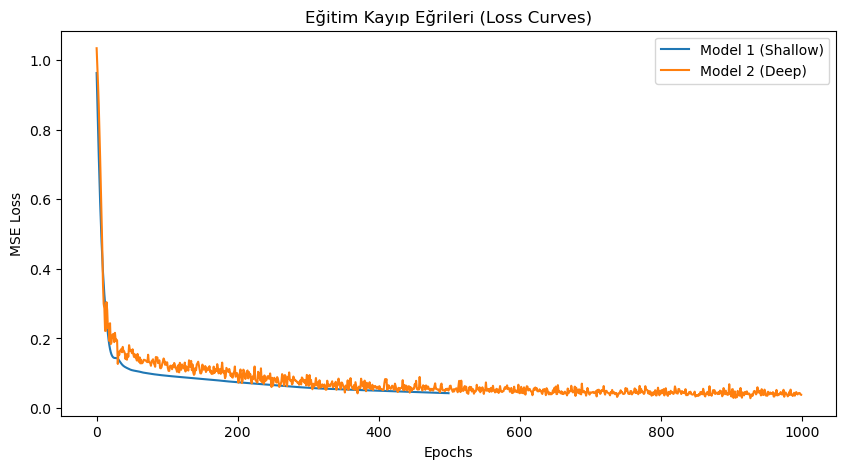


--- FİNAL KARŞILAŞTIRMA ---
               Model        RMSE  R2 Score
0   Lineer Regresyon   72.019897  0.901796
1  Model 1 (Shallow)  154.122316  0.550265
2  Model 2 (Deep)      90.109093  0.846268


In [12]:
# Sonuçların Görselleştirilmesi
plt.figure(figsize=(10, 5))
plt.plot(loss_history_1, label='Model 1 (Shallow)')
plt.plot(loss_history_2, label='Model 2 (Deep)')
plt.title('Eğitim Kayıp Eğrileri (Loss Curves)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

results_df = pd.DataFrame({
    'Model': ['Lineer Regresyon', 'Model 1 (Shallow)', 'Model 2 (Deep)   '],
    'RMSE': [rmse_lr, rmse_1, rmse_2],
    'R2 Score': [r2_lr, r2_1, r2_2]
})
print("\n--- FİNAL KARŞILAŞTIRMA ---")
print(results_df)

In [7]:
# Modelleri Kaydetme
if not os.path.exists('final_models'):
    os.makedirs('final_models')

torch.save(model_1.state_dict(), 'final_models/mukhammad_model1.pth')
torch.save(model_2.state_dict(), 'final_models/mukhammad_model2.pth')
joblib.dump(scaler_X, 'final_models/scaler_X.pkl')
joblib.dump(scaler_y, 'final_models/scaler_y.pkl')
results_df.to_csv('final_models/comparison_results.csv', index=False)

print("Modeller kaydedildi.")

Modeller kaydedildi.


In [8]:
# Detaylı Harita Görselleştirmesi (Enhanced Map Visualization)
# Bu kod, üzerine gelindiğinde (hover) tüm detayları gösteren haritalar oluşturur.

# 1. Veri Hazırlığı
map_data = df_clean.copy() # df_clean Hücre 2'den geliyor

# Gösterilecek Enerji Kaynakları
energy_sources = [
    'coal_share_elec', 'gas_share_elec', 'hydro_share_elec', 
    'nuclear_share_elec', 'oil_share_elec', 'solar_share_elec', 
    'wind_share_elec', 'biofuel_share_elec'
]

# Hover (Fare ile üzerine gelince) gösterilecek EKSTRA bilgiler
hover_details = energy_sources + ['gdp', 'population', 'energy_per_capita']

# Baskın kaynağı belirleme (Dominant Source)
map_data['dominant_source'] = map_data[energy_sources].idxmax(axis=1)
map_data['dominant_source'] = map_data['dominant_source'].str.replace('_share_elec', '').str.capitalize()

# --- HARİTA 1: Karbon Yoğunluğu (Detaylı) ---
fig1 = px.choropleth(
    map_data,
    locations="iso_code",
    color="carbon_intensity_elec",
    hover_name="country",
    hover_data=hover_details, # BURASI ÖNEMLİ: Tüm detayları ekledik
    color_continuous_scale="RdYlGn_r", # Kırmızı=Kirli, Yeşil=Temiz
    title="Dünya Geneli Karbon Yoğunluğu ve Enerji Detayları (2022)",
    labels={'carbon_intensity_elec': 'CO2 (g/kWh)', 'dominant_source': 'Ana Kaynak'}
)
fig1.update_layout(
    geo=dict(showframe=False, showcoastlines=True, projection_type='natural earth'),
    margin={"r":0,"t":30,"l":0,"b":0}
)

# --- HARİTA 2: Baskın Enerji Kaynağı ---
fig2 = px.choropleth(
    map_data,
    locations="iso_code",
    color="dominant_source",
    hover_name="country",
    hover_data=hover_details, # Tüm detayları buraya da ekledik
    title="Ülkelerin Enerji Profili ve Baskın Kaynaklar (2022)",
    labels={'dominant_source': 'Ana Kaynak'}
)
fig2.update_layout(
    geo=dict(showframe=False, showcoastlines=True, projection_type='natural earth'),
    margin={"r":0,"t":30,"l":0,"b":0}
)

# --- KAYDETME (HTML Olarak) ---
if not os.path.exists('maps'):
    os.makedirs('maps')

# Dosyaları kaydet
fig1.write_html("maps/carbon_map_detailed.html")
fig2.write_html("maps/energy_source_map_detailed.html")

print("BAŞARILI: Detaylı haritalar 'maps' klasörüne kaydedildi.")
print("1. maps/carbon_map_detailed.html (CO2 ve tüm veriler)")
print("2. maps/energy_source_map_detailed.html (Enerji kaynakları)")
print("Lütfen klasörü açıp bu dosyalara çift tıklayarak tarayıcıda inceleyin.")

BAŞARILI: Detaylı haritalar 'maps' klasörüne kaydedildi.
1. maps/carbon_map_detailed.html (CO2 ve tüm veriler)
2. maps/energy_source_map_detailed.html (Enerji kaynakları)
Lütfen klasörü açıp bu dosyalara çift tıklayarak tarayıcıda inceleyin.


In [9]:
# Enerji Politikası Simülatörü

def predict_emission(scenario_name, coal, gas, oil, hydro, solar, wind, nuclear, biofuel, gdp, pop, energy_capita):
    input_data = np.array([[biofuel, coal, solar, hydro, nuclear, oil, gas, wind, gdp, pop, energy_capita]])
    input_scaled = scaler_X.transform(input_data)
    input_tensor = torch.FloatTensor(input_scaled).to(device)
    
    model_2.eval()
    with torch.no_grad():
        pred_scaled = model_2(input_tensor).cpu().numpy()
        pred_actual = scaler_y.inverse_transform(pred_scaled)[0][0]
    return pred_actual

print("--- SİMÜLASYON SONUÇLARI ---")
current_co2 = predict_emission("Mevcut", 30, 30, 5, 20, 10, 5, 0, 0, 30000, 85000000, 5000)
green_co2 = predict_emission("Yeşil", 0, 30, 5, 20, 10, 15, 20, 0, 35000, 86000000, 5500)

print(f"Mevcut Senaryo: {current_co2:.2f} g/kWh")
print(f"Yeşil Senaryo: {green_co2:.2f} g/kWh")
print(f"Fark (Azalma): {current_co2 - green_co2:.2f} g/kWh")

--- SİMÜLASYON SONUÇLARI ---
Mevcut Senaryo: 493.00 g/kWh
Yeşil Senaryo: 208.38 g/kWh
Fark (Azalma): 284.62 g/kWh
